In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy

from psm_utils.psm import PSM
from psm_utils.psm_list import PSMList
from psm_utils.io import write_file
from deeplc import FeatExtractor



from sklearn.metrics import mean_absolute_error
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import callbacks
from scipy.stats import uniform, randint, pearsonr
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from IPython.display import display
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
#encoding by atomic composition 

infile = pd.read_csv("/home/emmy/Notebooks2/MQ_alignment_output/evidence_aligned_6.csv") #hier eigen aligned csv file aanroepen
infile.head()
psm_list = [] #psm_list is type object 
for idx,row in infile.iterrows():
    seq = row["Sequence"]
    charge = row["Charge"]  # Get the charge from the row

    peptidoform = f"{seq}/{charge}"

    psm_list.append(PSM(peptidoform=peptidoform,spectrum_id=idx))
    
psm_list = PSMList(psm_list=psm_list)

feat_extractor = FeatExtractor()
matrices = feat_extractor.encode_atoms(psm_list, list(range(len(psm_list))), predict_ccs=True)

In [3]:
data = pd.read_csv("/home/emmy/Notebooks2/MQ_alignment_output/evidence_aligned_6.csv") #reading in the data
ccs_df = data[['CCS']]
ccs_df.head()

,CCS
0,409.181586
1,675.752631
2,593.085242
3,682.043900
4,492.912110


In [4]:
matrix = np.stack(list(matrices["matrix"].values()))
matrix_all = np.stack(list(matrices["matrix_all"].values()))

In [5]:
# Split the data into training and testing sets
matrix_train, matrix_test, matrix_all_train, matrix_all_test, ccs_train, ccs_test = train_test_split(matrix, matrix_all, ccs_df, test_size=0.2, random_state=42)

In [6]:
# Further split the training data into training and validation sets if needed
matrix_train, matrix_val, matrix_all_train, matrix_all_val, ccs_train, ccs_val = train_test_split(matrix_train, matrix_all_train, ccs_train, test_size=0.1, random_state=42)

In [9]:
# Define input shapes
matrix_shape = (1148760, 60, 6)
matrix_all_shape = (1148760, 12)

# Define input layers for each matrix
input_matrix = Input(shape=(matrix_shape[1], matrix_shape[2]), name='matrix_input')
input_matrix_all = Input(shape=(matrix_all_shape[1],), name='matrix_input_all')

#Conv1D layer with maxpooling and globalmaxpooling
conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_matrix)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
globalmaxpooling_layer = GlobalMaxPooling1D()(maxpooling_layer)

# Concatenate with non-sequence data
concatenated_outputs = Concatenate()([globalmaxpooling_layer, input_matrix_all])

# Add dense layers with dropout and batch normalization
dense1 = Dense(units=1024, activation="relu")(concatenated_outputs)
dense2 = Dense(units=1014, activation="relu")(dense1)
dense3 = Dense(units=1024, activation="relu")(dense2)
dense4 = Dense(units=512, activation="relu")(dense3)
output = Dense(units=1)(dense4)

# Create the model
model_cnn = Model(inputs=[input_matrix, input_matrix_all], outputs=output)

# Compile the model
model_cnn.compile(optimizer='adam', loss='mae')

# Print the model summary
model_cnn.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 matrix_input (InputLayer)      [(None, 60, 6)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 58, 64)       1216        ['matrix_input[0][0]']           
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 29, 64)      0           ['conv1d_1[0][0]']               
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 64)          0           ['max_pooling1d_1[0][0]']        
 MaxPooling1D)                                                                              

In [ ]:
# Train the model with your input and output data
history_cnn = model_cnn.fit([matrix_train, matrix_all_train], ccs_train, epochs=20, batch_size=24, validation_data=([matrix_val, matrix_all_val], ccs_val))

history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df_cnn['val_loss'].min()))

In [3]:
%matplotlib inline

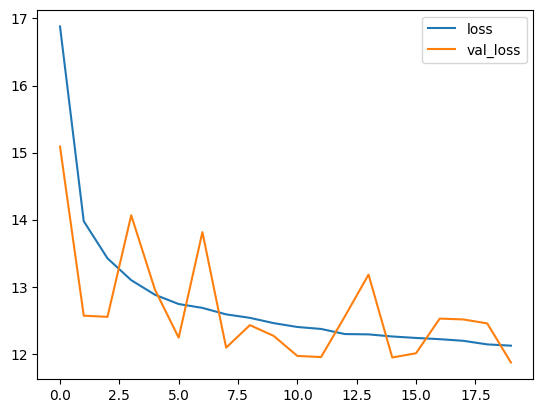

In [12]:
history_df_cnn = pd.read_csv('history_cnn.csv')
history_df_cnn.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


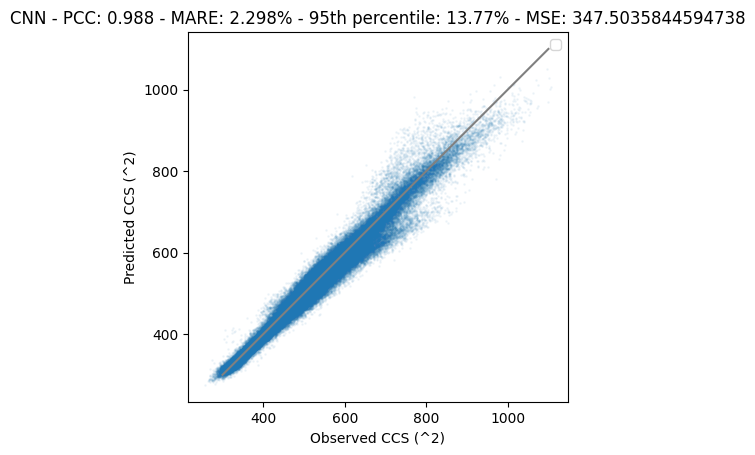

In [13]:
ccs_test_model_cnn = pd.read_csv('ccs_test_model_cnn.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn["CCS"],
    ccs_test_model_cnn["Model_cnn_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn["Model_cnn_predictions"]
true_ccs = ccs_test_model_cnn["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


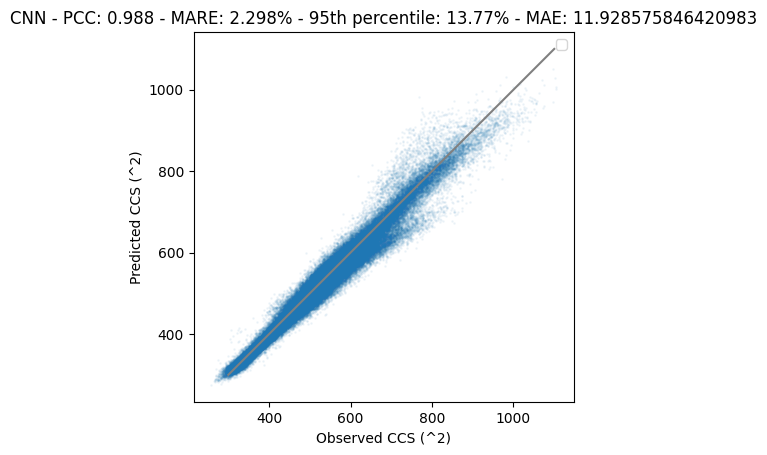

In [17]:
ccs_test_model_cnn = pd.read_csv('ccs_test_model_cnn.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn["CCS"],
    ccs_test_model_cnn["Model_cnn_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn["Model_cnn_predictions"]
true_ccs = ccs_test_model_cnn["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MAE
mae = mean_absolute_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MAE: {mae}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

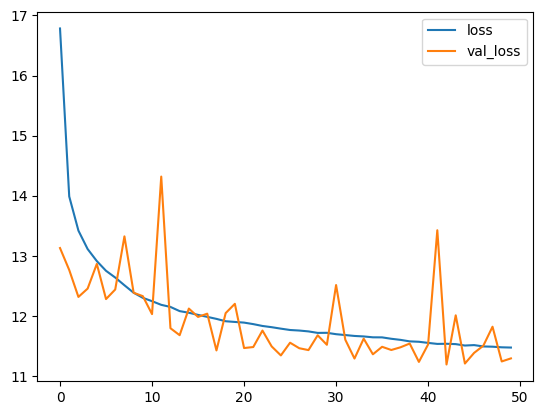

In [14]:
history_df_cnn2 = pd.read_csv('history_cnn2.csv')
history_df_cnn2.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


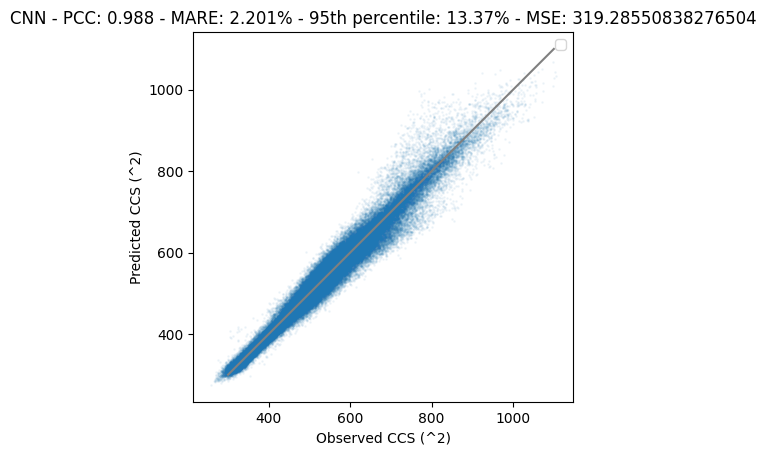

In [15]:
ccs_test_model_cnn2 = pd.read_csv('ccs_test_model_cnn2.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn2["CCS"],
    ccs_test_model_cnn2["Model_cnn2_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn2["Model_cnn2_predictions"]
true_ccs = ccs_test_model_cnn2["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


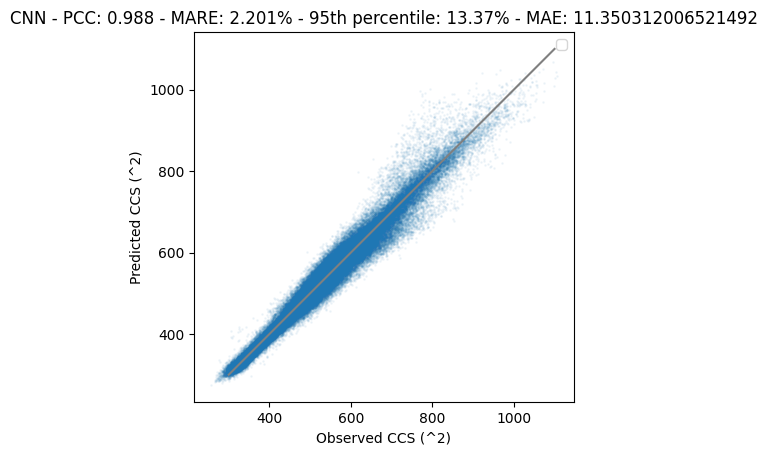

In [16]:
if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn2["CCS"],
    ccs_test_model_cnn2["Model_cnn2_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn2["Model_cnn2_predictions"]
true_ccs = ccs_test_model_cnn2["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MAE
mae = mean_absolute_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MAE: {mae}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

In [4]:
%matplotlib inline

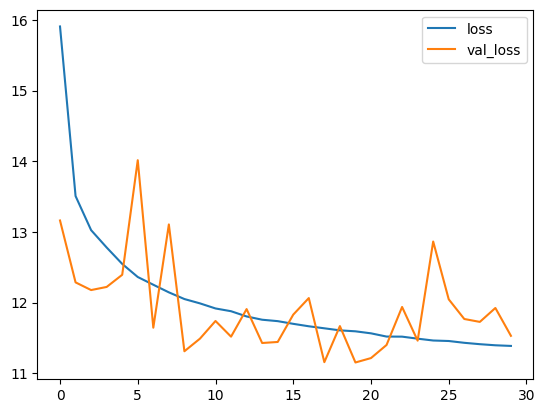

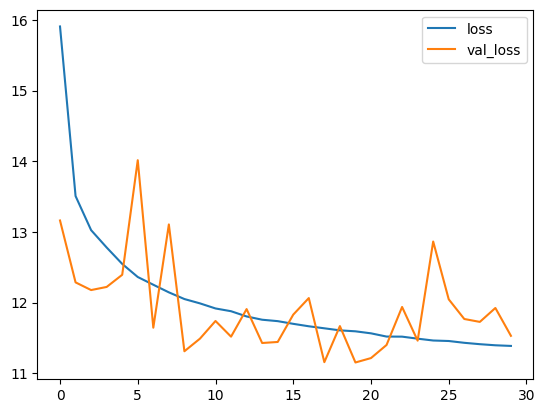

In [5]:
history_df_cnn3 = pd.read_csv('history_cnn3.csv')
history_df_cnn3.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


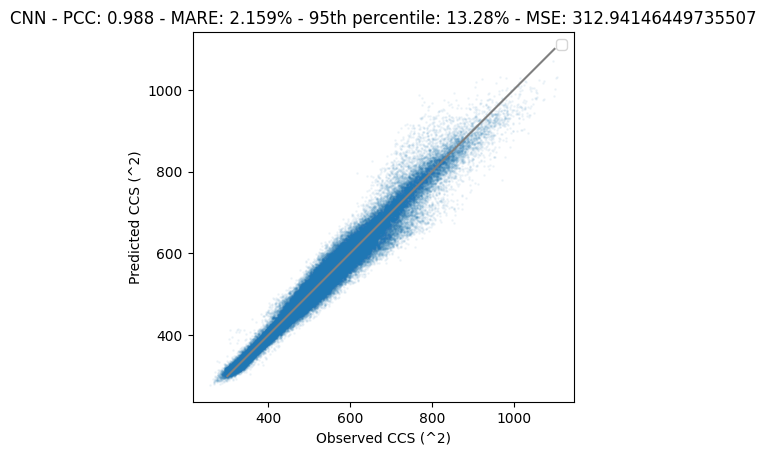

In [6]:
ccs_test_model_cnn3 = pd.read_csv('ccs_test_model_cnn3.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn3["CCS"],
    ccs_test_model_cnn3["Model_cnn3_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn3["Model_cnn3_predictions"]
true_ccs = ccs_test_model_cnn3["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


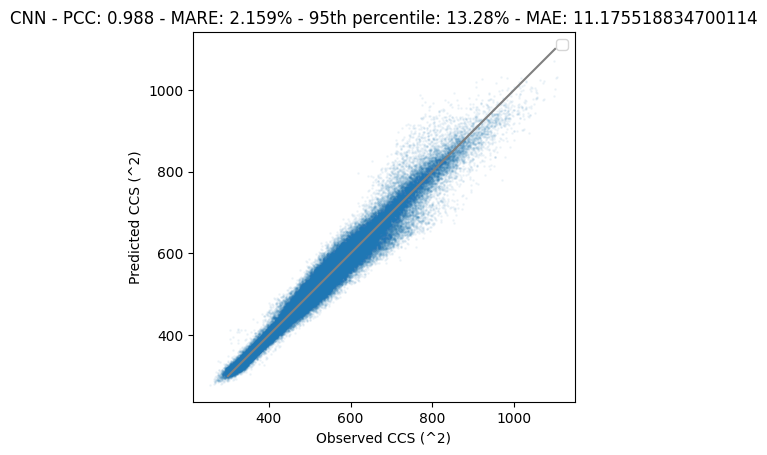

In [7]:
if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn3["CCS"],
    ccs_test_model_cnn3["Model_cnn3_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn3["Model_cnn3_predictions"]
true_ccs = ccs_test_model_cnn3["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MAE
mae = mean_absolute_error(true_ccs, predictions)

plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MAE: {mae}")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

In [9]:
# Define the model with more layers and neurons
# Assuming your input shapes
matrix_shape = (1148760, 60, 6)
matrix_all_shape = (1148760, 12)

# Define input layers for each matrix
input_matrix = Input(shape=(matrix_shape[1], matrix_shape[2]), name='matrix_input')
input_matrix_all = Input(shape=(matrix_all_shape[1],), name='matrix_input_all')

# Flatten the input matrices
flattened_matrix = Flatten()(input_matrix)
flattened_matrix_all = input_matrix_all  # No need to flatten

# Concatenate the flattened and non-flattened outputs
concatenated_outputs = Concatenate()([flattened_matrix, flattened_matrix_all])


dense1 = Dense(units=1024, activation = "relu")(concatenated_outputs)
dense2 = Dense(units=1014, activation = "relu")(dense1)
dense3 = Dense(units=1024, activation = "relu")(dense2)
dense4 = Dense(units=512, activation = "relu")(dense3)
output = Dense(units=1)(dense4)

# Create the model
model3 = Model(inputs=[input_matrix, input_matrix_all], outputs=output)


# Compile the model

model3.compile(
    optimizer='adam',
    loss='mae'
)

2024-04-23 15:48:26.079526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-23 15:48:26.079638: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 matrix_input (InputLayer)      [(None, 60, 6)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 360)          0           ['matrix_input[0][0]']           
                                                                                                  
 matrix_input_all (InputLayer)  [(None, 12)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 372)          0           ['flatten[0][0]',                
                                                                  'matrix_input_all[0][0]']   

In [9]:
pip install pydot graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


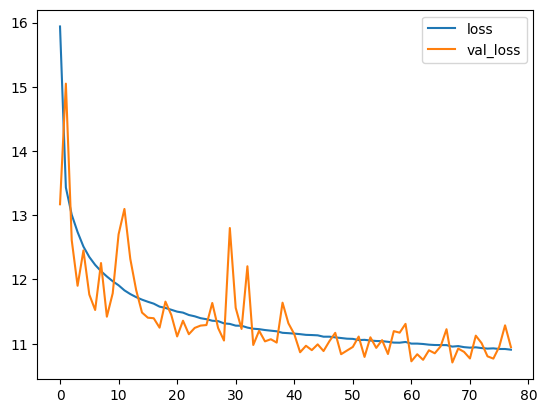

In [4]:
history_df_cnn4 = pd.read_csv('history_cnn4.csv')
history_df_cnn4.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


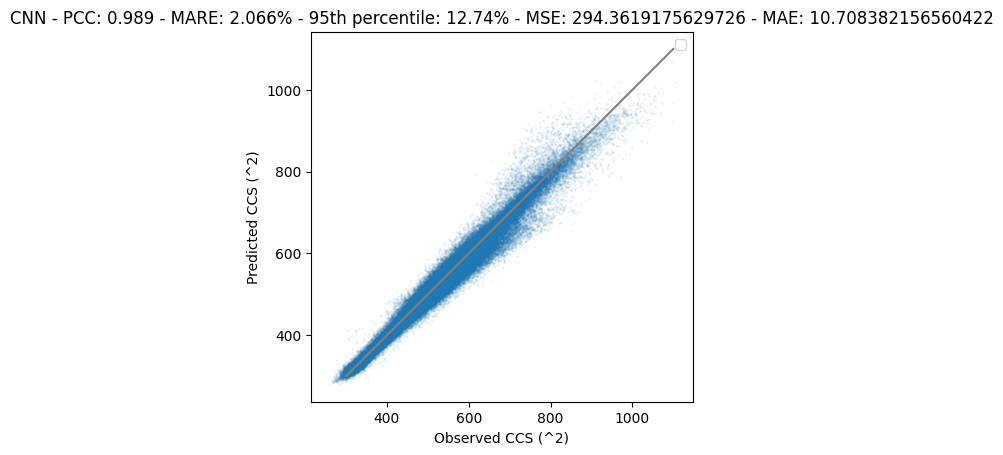

In [5]:
ccs_test_model_cnn4 = pd.read_csv('ccs_test_model_cnn4.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn4["CCS"],
    ccs_test_model_cnn4["Model_cnn4_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn4["Model_cnn4_predictions"]
true_ccs = ccs_test_model_cnn4["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)
mae = mean_absolute_error(true_ccs, predictions)


plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse} - MAE: {mae}" )

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

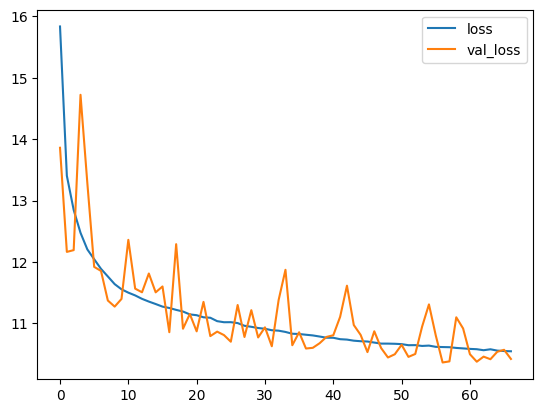

In [4]:
history_df_cnn5 = pd.read_csv('history_cnn5.csv')
history_df_cnn5.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


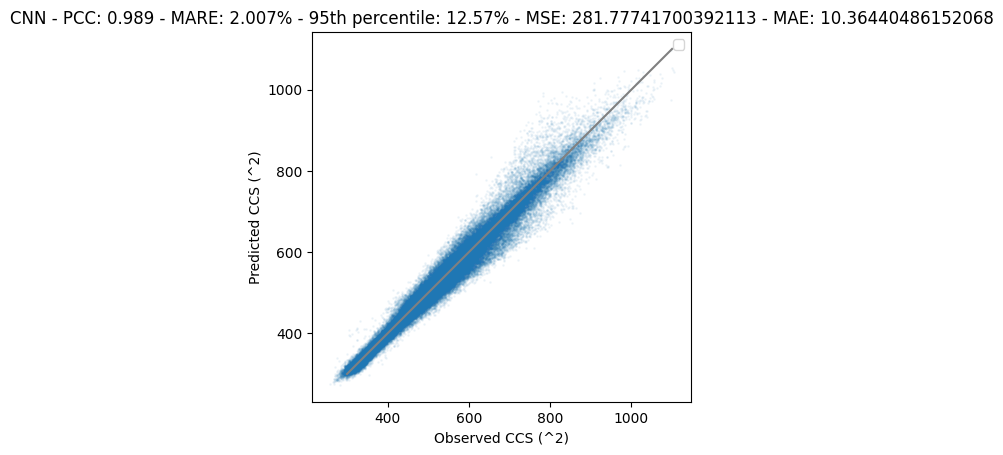

In [5]:
ccs_test_model_cnn5 = pd.read_csv('ccs_test_model_cnn5.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn5["CCS"],
    ccs_test_model_cnn5["Model_cnn5_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn5["Model_cnn5_predictions"]
true_ccs = ccs_test_model_cnn5["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)
mae = mean_absolute_error(true_ccs, predictions)


plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse} - MAE: {mae}" )

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

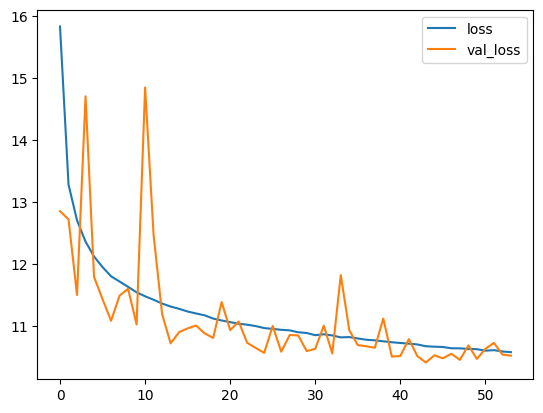

In [4]:
history_df_cnn6 = pd.read_csv('history_cnn6.csv')
history_df_cnn6.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


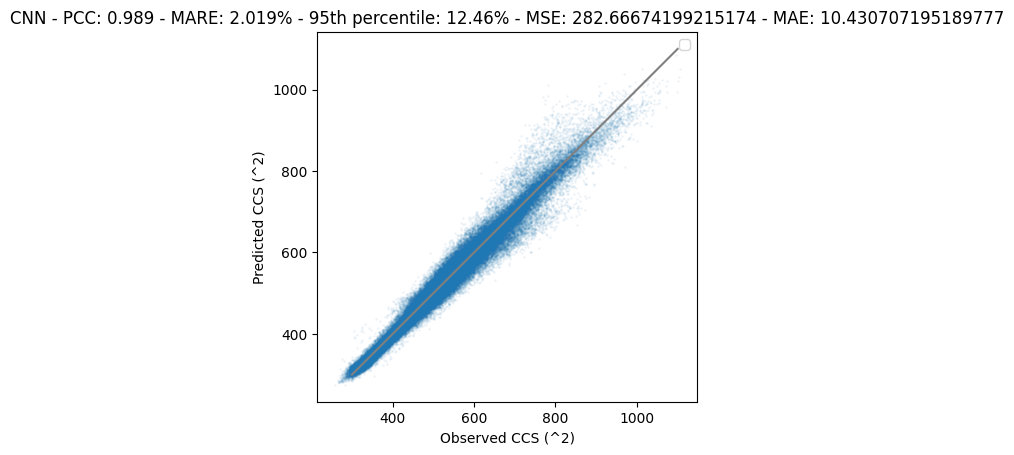

In [5]:
ccs_test_model_cnn6 = pd.read_csv('ccs_test_model_cnn6.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn6["CCS"],
    ccs_test_model_cnn6["Model_cnn6_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn6["Model_cnn6_predictions"]
true_ccs = ccs_test_model_cnn6["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)
mae = mean_absolute_error(true_ccs, predictions)


plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse} - MAE: {mae}" )

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

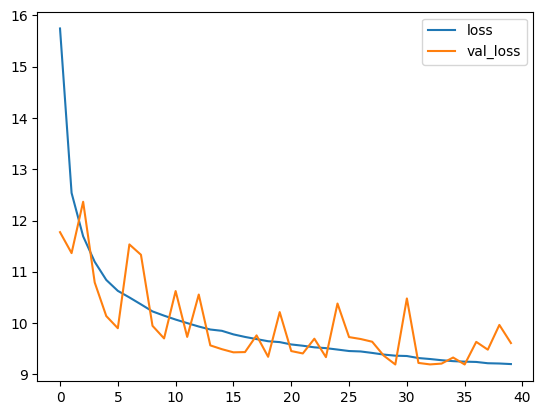

In [4]:
history_df_cnn7 = pd.read_csv('history_cnn7.csv')
history_df_cnn7.loc[:, ['loss', 'val_loss']].plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


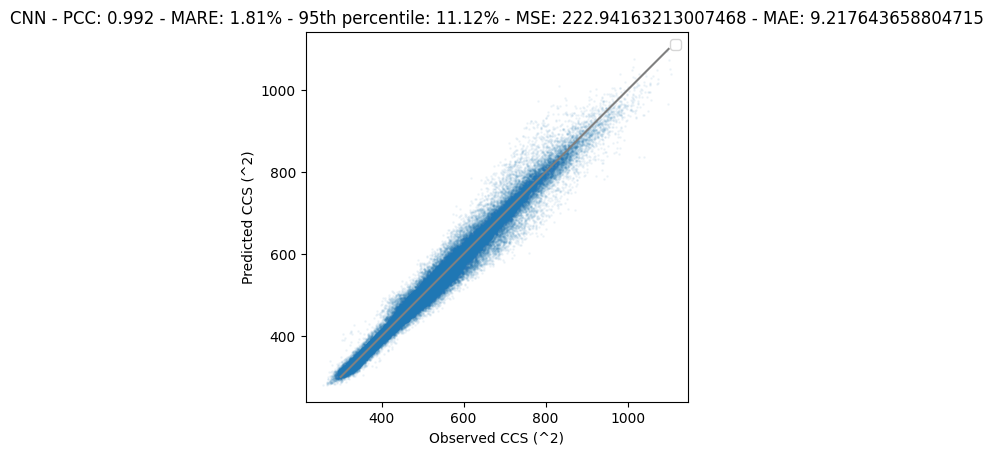

In [5]:
ccs_test_model_cnn7 = pd.read_csv('ccs_test_model_cnn7.csv')

if len(ccs_df.index) < 1e4:
    set_alpha = 0.2
    set_size = 3
else:
    set_alpha = 0.05
    set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn7["CCS"],
    ccs_test_model_cnn7["Model_cnn7_predictions"],
    alpha=set_alpha,
    s=set_size,
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn7["Model_cnn7_predictions"]
true_ccs = ccs_test_model_cnn7["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
pcc = round(pearsonr(predictions,true_ccs)[0],3)
perc_95 = round(np.percentile((abs(predictions-true_ccs)/true_ccs)*100,95)*2,2)

# Calculate MSE
mse = mean_squared_error(true_ccs, predictions)
mae = mean_absolute_error(true_ccs, predictions)


plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse} - MAE: {mae}" )

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()

In [7]:
# Define the input shapes
matrix_shape = (1148760, 60, 6)
matrix_all_shape = (1148760, 12)

# Define input layers for each matrix
input_matrix = Input(shape=(matrix_shape[1], matrix_shape[2]), name='matrix_input')
input_matrix_all = Input(shape=(matrix_all_shape[1],), name='matrix_input_all')

# First Conv1D layer
conv1d_layer1 = Conv1D(filters=64, kernel_size=5, activation='relu')(input_matrix)
maxpooling_layer1 = MaxPooling1D(pool_size=2)(conv1d_layer1)

# Second Conv1D layer
conv1d_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(maxpooling_layer1)
maxpooling_layer2 = MaxPooling1D(pool_size=2)(conv1d_layer2)

# Third Conv1D layer
conv1d_layer3 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxpooling_layer2)
maxpooling_layer3 = MaxPooling1D(pool_size=2)(conv1d_layer3)

# Global max pooling layer
globalmaxpooling_layer = GlobalMaxPooling1D()(maxpooling_layer3)

# Concatenate with non-sequence data
concatenated_outputs = Concatenate()([globalmaxpooling_layer, input_matrix_all])

# Add dense layers 
dense1 = Dense(units=1024, activation = "relu")(concatenated_outputs)
dense2 = Dense(units=1014, activation = "relu")(dense1)
dense3 = Dense(units=1024, activation = "relu")(dense2)
dense4 = Dense(units=512, activation = "relu")(dense3)
output = Dense(units=1)(dense4)

# Create the model
model_cnn7 = Model(inputs=[input_matrix, input_matrix_all], outputs=output)

# Compile the model
model_cnn7.compile(optimizer=Adam(learning_rate = 0.0003), loss='mae')

# Print the model summary
model_cnn7.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 matrix_input (InputLayer)      [(None, 60, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 56, 64)       1984        ['matrix_input[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 28, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 26, 64)       12352       ['max_pooling1d[0][0]']          
                                                                                              

In [5]:
%matplotlib inline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


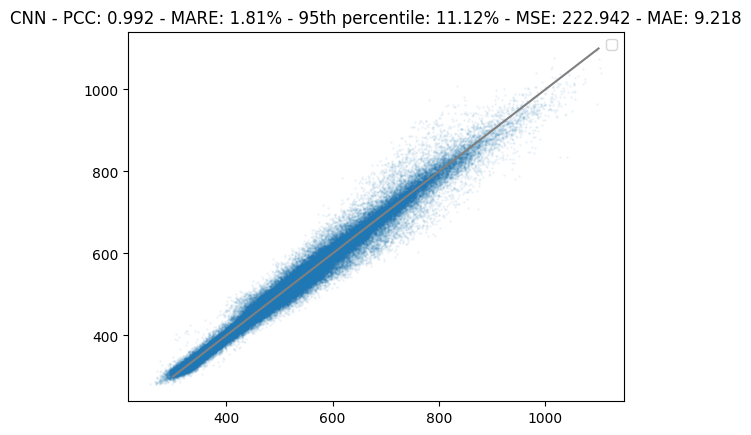

In [8]:
ccs_test_model_cnn7 = pd.read_csv('/home/emmy/Notebooks2/output_CNN/ccs_test_model_cnn7.csv')


set_alpha = 0.05
set_size = 1

# Scatter plot the observations on the test set against the predictions on the same set
plt.scatter(
    ccs_test_model_cnn7["CCS"],
    ccs_test_model_cnn7["Model_cnn7_predictions"],
    alpha=set_alpha,
    s=set_size,
    color = "tab:blue",
)



# Plot a diagonal the points should be one
plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

# Get the predictions and calculate performance metrics
predictions = ccs_test_model_cnn7["Model_cnn7_predictions"]
true_ccs = ccs_test_model_cnn7["CCS"]
mare = round(sum((abs(predictions-true_ccs)/true_ccs)*100)/len(predictions),3)
plt.title(f"CNN - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% - MSE: {mse:.3f} - MAE: {mae:.3f}")

plt.show()